# Demonstration of linear mosaic

Reads a CASA MeasurementSet containing 7 pointing observation of CASA at 8.4 GHz, forms linear mosaic of dirty images

In [1]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from data_models.parameters import arl_path

from libs.image.iterators import image_raster_iter

from processing_components.visibility.base import create_visibility, create_visibility_from_ms
from processing_components.skycomponent.operations import create_skycomponent
from processing_components.image.operations import show_image, copy_image
from processing_components.image.deconvolution import deconvolve_cube
from processing_components.visibility.iterators import vis_timeslice_iter
from processing_components.simulation.testing_support import create_named_configuration
from processing_components.imaging.primary_beams import create_pb
from processing_components.imaging.base import create_image_from_visibility, invert_2d
from processing_components.imaging.weighting import weight_visibility

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

In [3]:
vis_list=create_visibility_from_ms(arl_path('data/vis/xcasa.ms'))

create_blockvisibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_blockvisibility_from_ms: Found unique fields [0 1 2 3 4 5 6], unique data descriptions [0 1]
create_blockvisibility_from_ms: Found 28554 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 14840 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 12047 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 11814 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 11858 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 11682 rows
create_visibility_from_ms: Found 1 channels
create_blockvisibility_from_ms: Found 11573 rows
create_visibility_from_ms: Found 1 channels
create_blockvisib

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


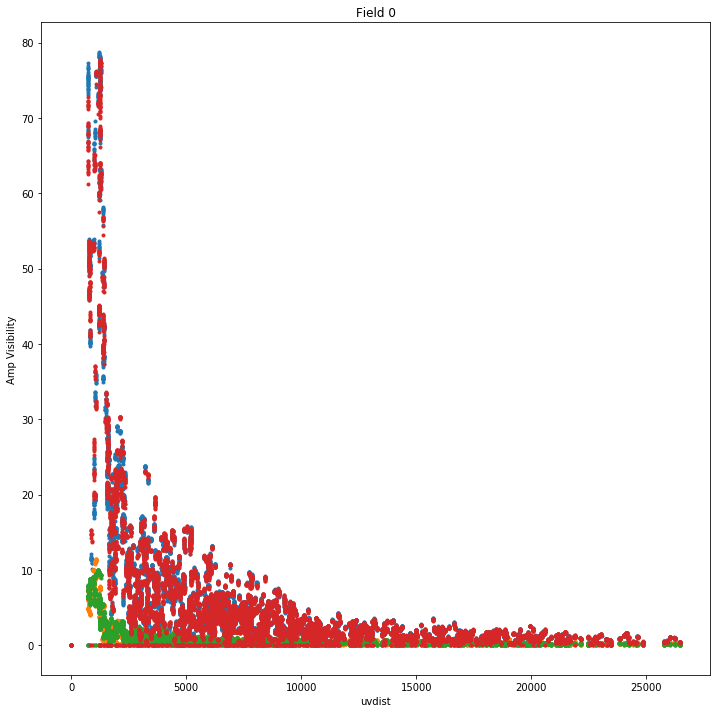

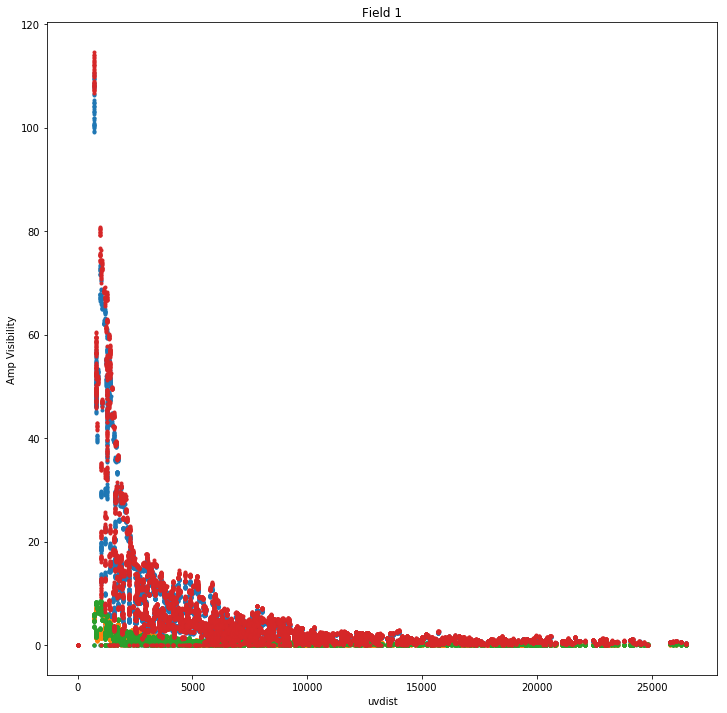

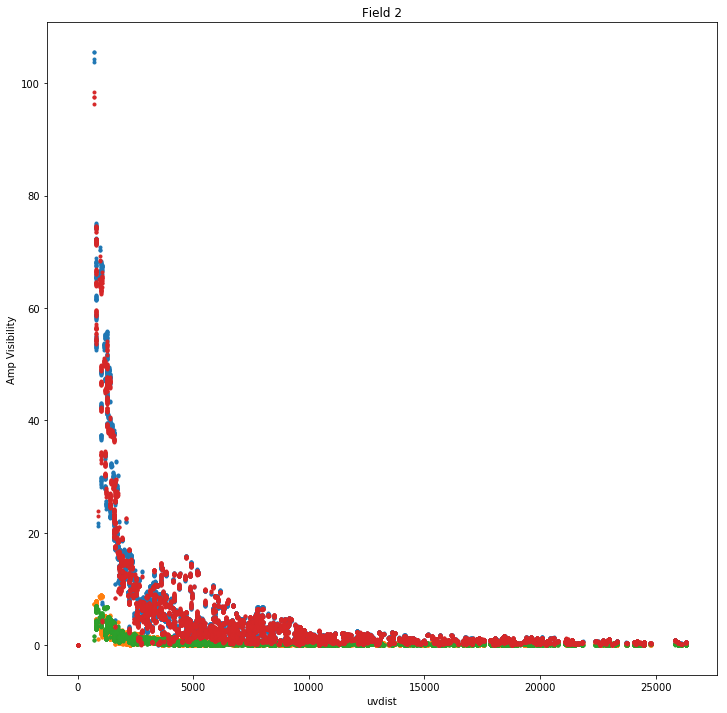

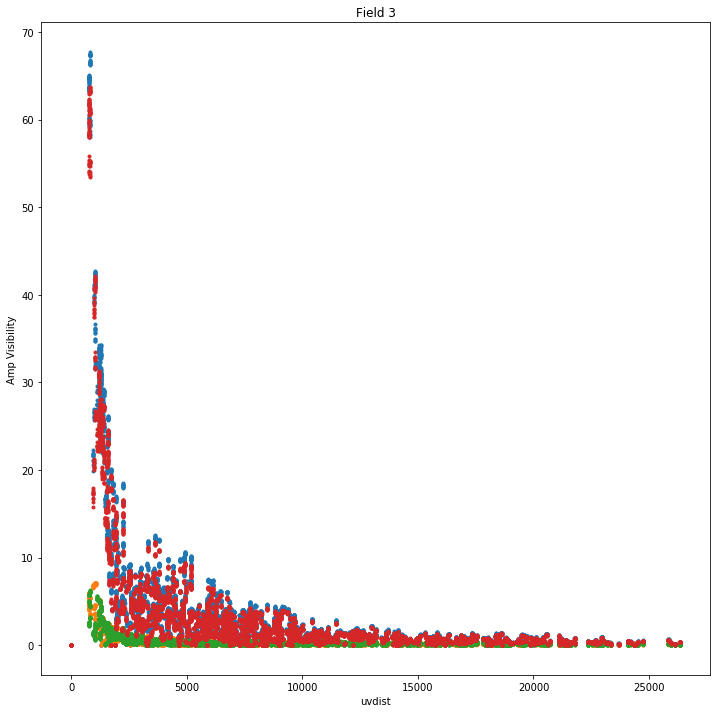

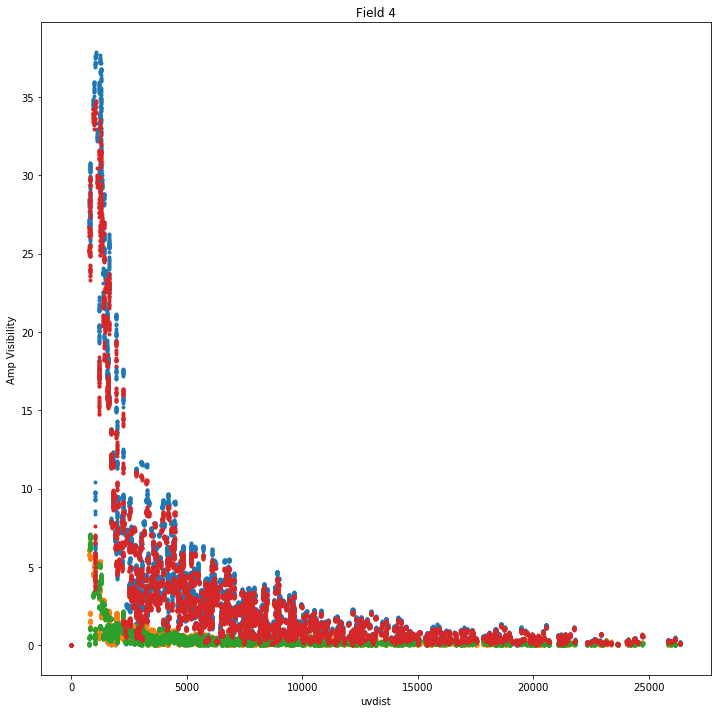

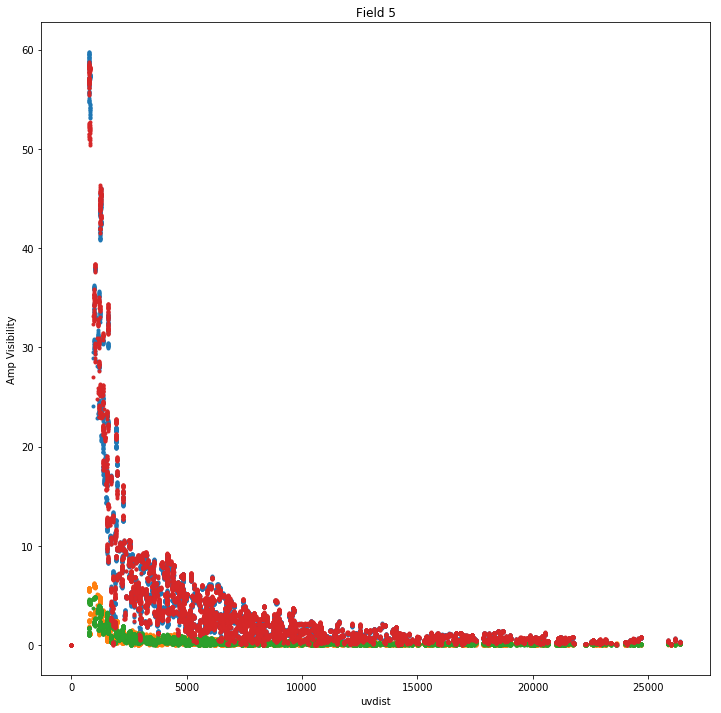

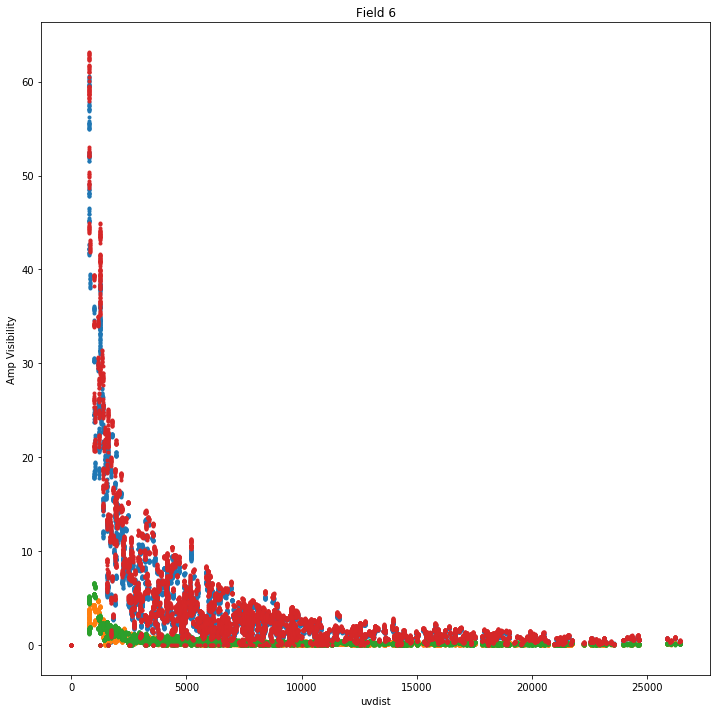

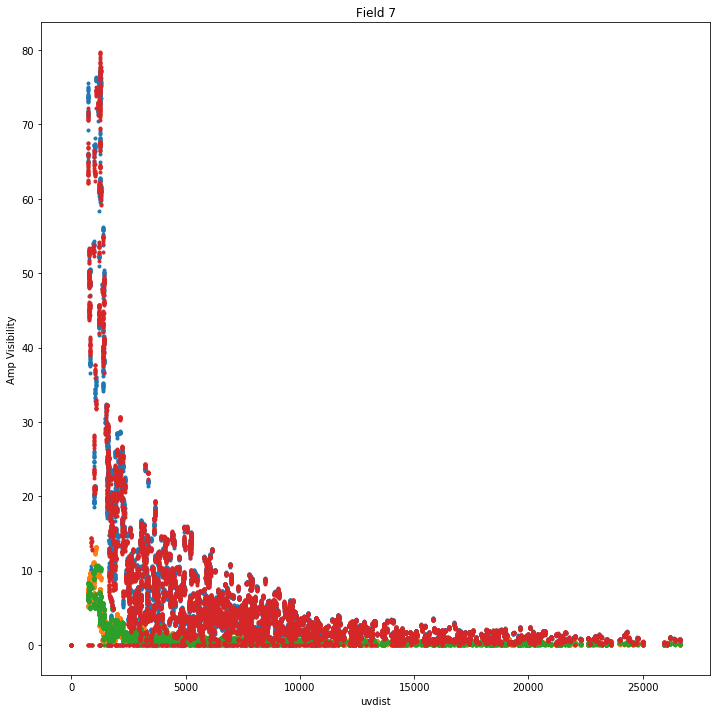

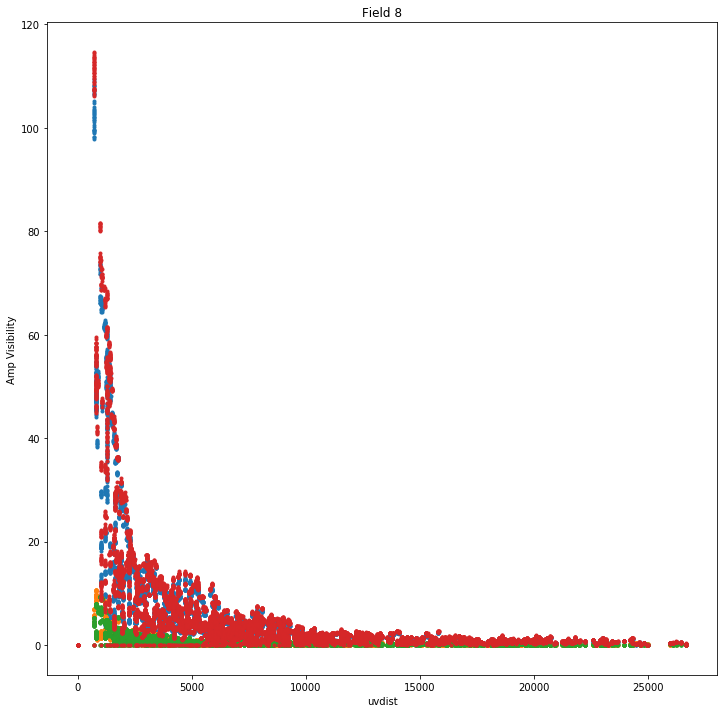

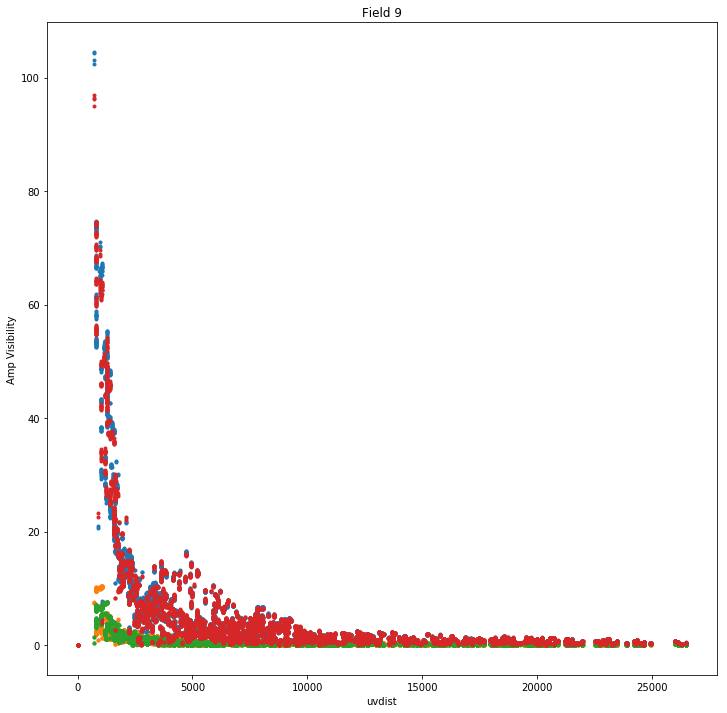

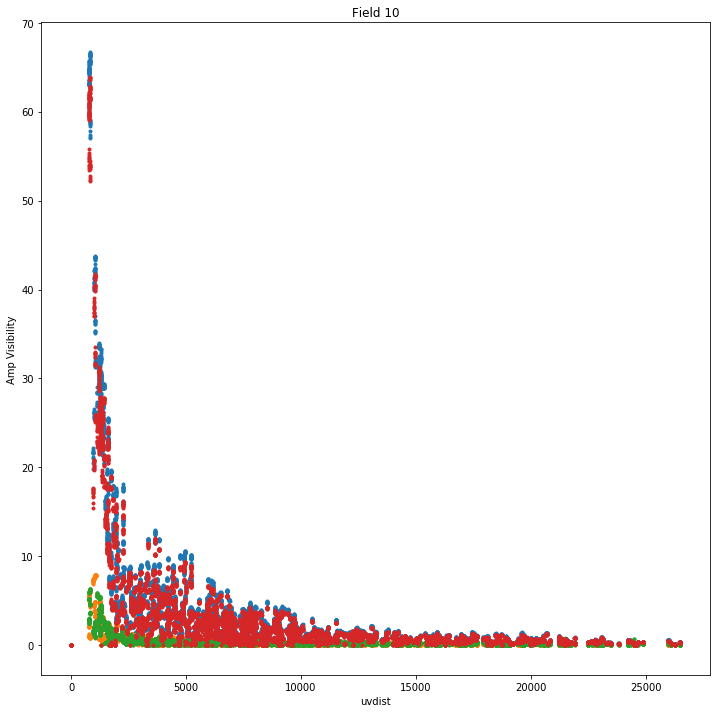

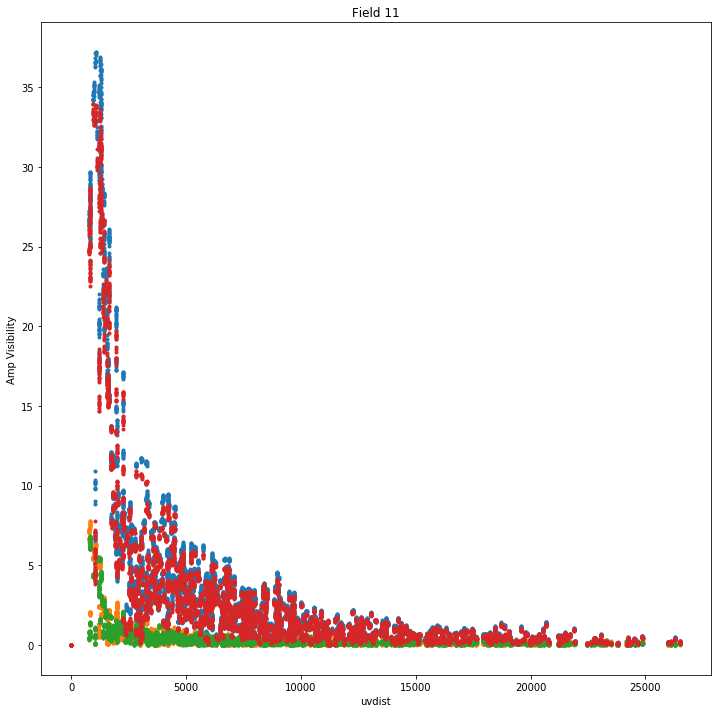

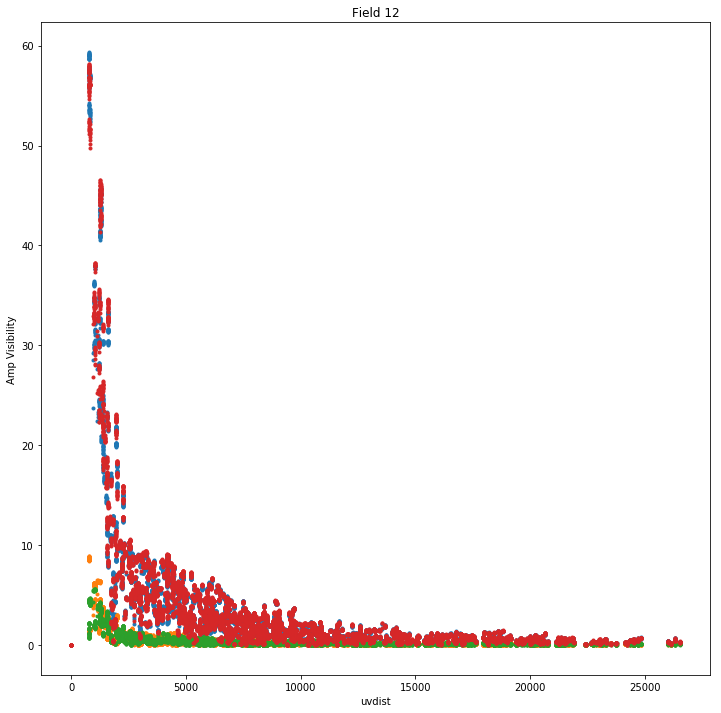

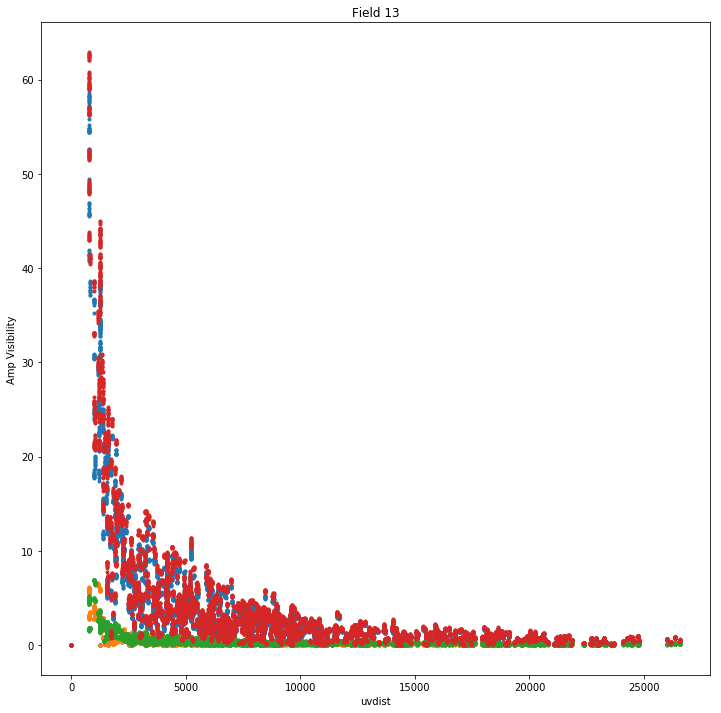

In [4]:
# plot the amplitude of the visibility for each field
for field, vt in enumerate(vis_list):
    uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.title('Field %d' % (field))
    plt.show()

Make the dirty images

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    [(350.30416667, 58.54305556)]>, starting frequency 8435100000.0 Hz, and bandwidth 49999999.9995 Hz
create_image_from_visibility: uvmax = 17492.300781 wavelengths
create_image_from_visibility: Critical cellsize = 0.000029 radians, 0.001638 degrees
create_image_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.21, 58.54305556)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    [(350.25708333, 58.5875)]> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (350.30416667, 58.54305556)>
shift_vis_from_image: shifting phasecentre from vis phas

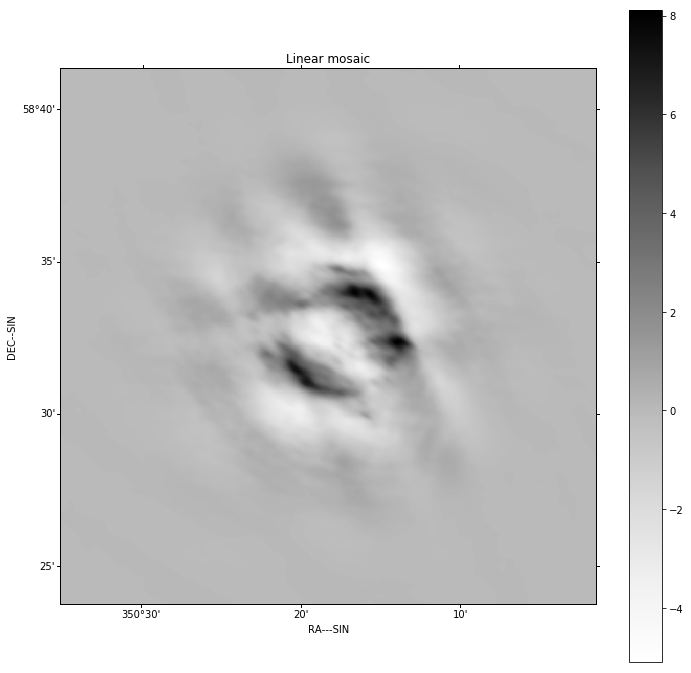

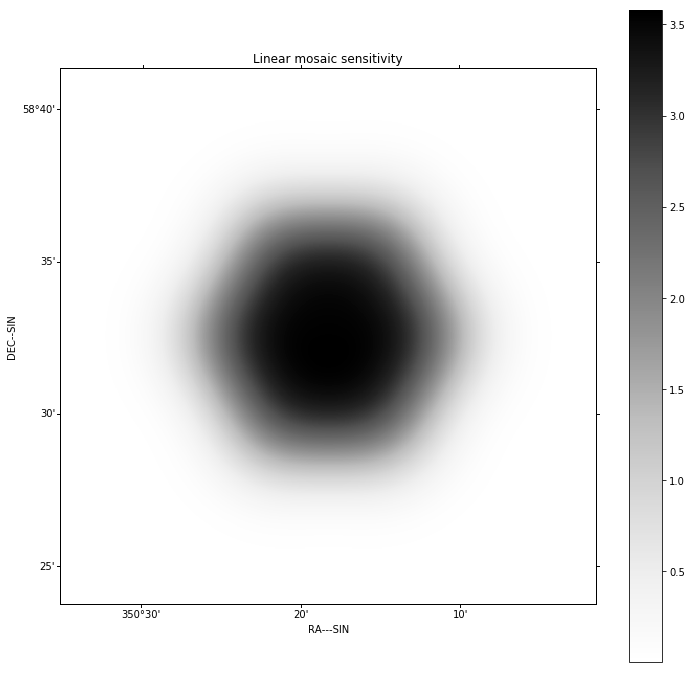

In [5]:
cellsize=0.00001

model = create_image_from_visibility(vis_list[0], cellsize=cellsize, npixel=512, nchan=1, 
                                     imagecentre=vis_list[0].phasecentre,
                                     polarisation_frame=PolarisationFrame('stokesIQUV'))
mosaic = copy_image(model)
mosaicsens = copy_image(model)
work = copy_image(model)

for vt in vis_list:
    beam = create_pb(model, telescope='VLA', pointingcentre=vt.phasecentre)
    beam.data /= numpy.max(beam.data)
    dirty, sumwt = invert_2d(vt, model)
    mosaic.data += dirty.data * beam.data
    mosaicsens.data += beam.data**2
    
show_image(mosaic, cm='Greys', title='Linear mosaic')
plt.show()
show_image(mosaicsens, cm='Greys', title='Linear mosaic sensitivity')
plt.show()


In [6]:
from libs.griddata.operations import fft_image_to_griddata

ModuleNotFoundError: No module named 'libs.griddata'

In [ ]:
gd = fft_image_to_griddata(mosaicsens)

In [ ]:
from libs.griddata.operations import convert_griddata_to_image
im=convert_griddata_to_image(gd)
im.data = numpy.real(im.data)
from processing_components.image.operations import export_image_to_fits
export_image_to_fits(im, "mosaicsens.fits")

In [ ]:
show_image(im)
plt.show()